# TODO here
- clean up import list

- are the last cells really needed?

# Creating the car and bike networks
- Get all OSM paths according to a list of tags within the boundary + user-defined buffer
- drop edges that aren't clearly for bikes or cars
- create conditions to classify edges as part of the bike or car network
- classify the edges according to those conditions
- simplify the graph (remove interstitial nodes, keep accurate edge geometries)
- create dictionary of node/edge attributes
- turn list of nodes/edges into 2 separate NetworkX networks (one for bike one for car) 
- TODO: anyhting else here?

In [3]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os
from shapely.geometry import Polygon
import shapely
os.environ['USE_PYGEOS'] = '0' 

# helper functions for street network 
from bikefun import *
import simplification as custom_simplification


# User settings
place_name = "Grand Paris Metropolis"
crs_fr = 2154 
plt.rcParams['figure.figsize'] = (8, 8)

GPM = ox.geocode_to_gdf(place_name)
GPM = GPM.to_crs(crs_fr)

## Get the car and bike network (Anastassia way)

In [2]:
# tags to import:
osm_way_tags = [
  # "access", 
  "barrier", 
  # "bridge", 
  "bicycle", 
  "bicycle_road",
  "crossing",
  "cycleway", "cycleway:left", "cycleway:right", "cycleway:both", "cycleway:buffer", "cycleway:left:buffer", "cycleway:right:buffer", "cycleway:both:buffer",
  # "cycleway:width", "cycleway:left:width", "cycleway:right:width", "cycleway:both:width",
  # "cycleway:surface",
  "foot", "footway",
  "highway", 
  # "incline", "junction", "layer", "lit", 
  # "maxspeed", 
  # "maxspeed:advisory",
  # "moped", 
  # "motor_vehicle", 
  # "motorcar",
  "name",
  # "oneway", "oneway:bicycle",
  "osm_id",
  "segregated",
  # "surface",
  "tracktype",
  # "tunnel",
  # "width"
]

ox.settings.useful_tags_way = osm_way_tags

# don't use cache
ox.settings.use_cache = False
buffer_dist = 2000

**Download data for GPM plus a user-defined (above) buffer** 

In [3]:
# Get convex hull of the area
GPM_hull = gpd.GeoDataFrame({"geometry": GPM.convex_hull})
GPM_hull = GPM_hull.to_crs(crs_fr)

# Buffer the convex hull
GPM_hull_buff = gpd.GeoDataFrame({"geometry": GPM_hull.buffer(buffer_dist)})
GPM_hull_buff = GPM_hull_buff.to_crs(crs_fr)

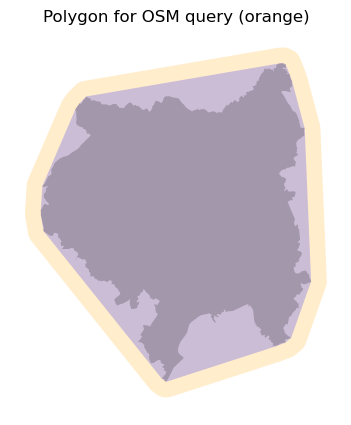

In [4]:
# Visualize results - orange area will be used for data query from OSM
fig, ax = plt.subplots(1, 1, figsize = (5,5))
GPM_hull_buff.plot(ax = ax, color = "orange", alpha=0.2)
GPM_hull.plot(ax = ax, color = "blue", alpha = 0.2)
GPM.plot(ax = ax, color = "black", alpha = 0.2)
plt.title("Polygon for OSM query (orange)")
plt.axis("off");

In [5]:
mygraph = ox.graph_from_polygon(
    polygon = GPM_hull_buff.to_crs("epsg:4326")["geometry"][0],
    network_type = "all_private",
    simplify = False,
    retain_all = False,
    truncate_by_edge = True,
    clean_periphery = False 
)

/Users/auriane/opt/miniconda3/envs/gds/lib/python3.8/site-packages/osmnx/graph.py:488: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  warnings.warn(msg)


In [6]:
# convert to gdf of edges

nodes, edges = ox.graph_to_gdfs(
    mygraph, 
    nodes = True,
    edges = True,
    fill_edge_geometry = True)
print(len(edges), "edges") # should be 2952228 for GPM + buffer

2891808 edges


**Exclude edges tagged as highway=service/pedestrian/path/elevator/steps**

In [7]:
edges = edges.drop(edges[edges["highway"]=="service"].index)
edges = edges.drop(edges[edges["highway"]=="path"].index)
edges = edges.drop(edges[edges["highway"]=="pedestrian"].index)
edges = edges.drop(edges[edges["highway"]=="footway"].index)
edges = edges.drop(edges[edges["highway"]=="elevator"].index)
edges = edges.drop(edges[edges["highway"]=="steps"].index)
print(len(edges), "edges")

1323580 edges


**Clean column names (so that we can use .query)**

In [8]:
edges = clean_col_names(edges)

**Summarize tags into bnw (bike network) and cnw (car network) classifications**

In [9]:
# add bnw and cnw columns (filled with empty lists, where we will add reasons why these edges should be part of the cnw or bnw network)
edges["bnw_reasons"] = edges.apply(lambda x: [], axis = 1)
edges["cnw_reasons"] = edges.apply(lambda x: [], axis = 1)

In [10]:
### REASONS FOR EDGES TO BE INCLUDED IN BNW

# If the highway tag is "cycleway", edge is part of bnw
edges.query(
    "highway=='cycleway'").loc[:,"bnw_reasons"].apply(
        lambda x: x.append("highway is cycleway"));

# if there is a segregation tag, edge is part of bnw:
edges.query(
    "segregated.notna()").loc[:,"bnw_reasons"].apply(
        lambda x: x.append("segregation tag exists"));

# If cycleway (_, left, right, both) tag exists and has value "track" or "separated", edge is part of bnw
edges.query(
    "cycleway in ['track', 'separated', 'segregated', 'designated', 'opposite_track']").loc[:,"bnw_reasons"].apply(
        lambda x: x.append("cycleway is in track or separated"));
edges.query(
    "cycleway_left in ['track', 'separated', 'segregated', 'designated', 'opposite_track']").loc[:,"bnw_reasons"].apply(
        lambda x: x.append("cycleway_left is in track or separated"));
edges.query(
    "cycleway_right in ['track', 'separated', 'segregated', 'designated', 'opposite_track']").loc[:,"bnw_reasons"].apply(
        lambda x: x.append("cycleway_right is in track or separated"));
edges.query(
    "cycleway_both in ['track', 'separated', 'segregated', 'designated', 'opposite_track']").loc[:,"bnw_reasons"].apply(
        lambda x: x.append("cycleway_both is in track or separated"));

In [11]:
### REASONS FOR EDGES TO BE INCLUDED IN CNW

# if cyclists need to dismount: (after we have excluded pedestrian/path):
edges.query(
    "bicycle=='dismount'").loc[:,"cnw_reasons"].apply(
        lambda x: x.append("dismount"));

# OR, last argument: if no "bnw" arguments have been found
# edges["cnw_reasons"] = edges.apply(lambda x: len(x.bnw_reasons)==0, axis = 1)
edges[edges.apply(lambda x: len(x.bnw_reasons), axis = 1) == 0].loc[:,"cnw_reasons"].apply(lambda x: x.append("no bnw reasons"))

u            v            key
122642       4323059590   0      None
             1892391802   0      None
122922       2841312675   0      None
             2841312678   0      None
122923       515623637    0      None
                                 ... 
10758516278  550121181    0      None
10758516279  1516967443   0      None
             10758516280  0      None
10758516280  10758516279  0      None
             1516967439   0      None
Name: cnw_reasons, Length: 1221730, dtype: object

In [12]:
### Classify edges based on reasons for classification into either bnw or cnw

edges["bnw"] = edges.apply(lambda x: len(x.bnw_reasons)>0, axis = 1)
edges["cnw"] = edges.apply(lambda x: len(x.cnw_reasons)>0, axis = 1)

### Check for consistency
# MOD: added some text to the print
# any edges classified as both bnw and cnw?
print("both bnw and cnw: ", len(edges[(edges["cnw"]==True)&(edges["bnw"]==True)]), "edges")
# any edges not classified at all?
print("not classified: ", len(edges[(edges["cnw"]==False)&(edges["bnw"]==False)]), "edges")



both bnw and cnw:  4 edges
not classified:  0 edges


In [13]:
### add 1 column which only contains attribute
edges["edgetype"] = None

# MOD: "car" became "bike", added case where both conditions == True 
def get_edgetype(bnw, cnw):
    if bnw==False and cnw==True:
        return "car"
    elif bnw==True and cnw==False:
        return "bike"
    elif bnw==True and cnw==True:
        return "both"
    else:
        return None
    
edges["edgetype"] = edges.apply(lambda x: get_edgetype(bnw=x.bnw, cnw=x.cnw), axis = 1)

In [14]:
# MOD not keeping the geometry column
edges_nogeom = edges[["osmid", "edgetype", 'length', 'oneway']]

edges_nogeom = edges_nogeom.reset_index()
edges_nogeom['osmid'] = edges_nogeom['osmid'].astype(str)
edges_nogeom.set_index(['u', 'v','key'], inplace=True)
edges_nogeom.head()

# RUN THIS IF NOT RUNNING FOR THE QGIS CHECK
edges_nogeom = edges[["osmid", "edgetype"]]

# MOD dropping edges with key =/= 0
edges_nogeom = edges_nogeom.query('key == 0')

In [15]:
# create graph 
G_nogeom = ox.graph_from_gdfs(gdf_nodes = nodes, gdf_edges = edges_nogeom, graph_attrs=edges)
G_nogeom.graph["crs"] = edges.crs

# drop nodes with degree 0
nodes_to_remove = []
for node in G_nogeom.nodes:
    if nx.degree(G_nogeom, node) == 0:
        nodes_to_remove.append(node)
for node in nodes_to_remove:
    G_nogeom.remove_node(node)

In [16]:
# simplify
G_nogeom_simp = custom_simplification.simplify_graph(G = G_nogeom, attributes = "edgetype")
G_nogeom_simp.graph["crs"] = edges.crs

In [17]:
# Save into gdfs
nodes_simp_nogeom, edges_simp_nogeom = ox.graph_to_gdfs(
    G_nogeom_simp, 
    nodes = True,
    edges = True,
    fill_edge_geometry = True)

In [18]:
# # Check in QGIS
# # To run this, you need to uncomment some stuff above and re-run the code!
# nodes_simp_nogeom.to_file("./data/processed/bike_car_nodes_simp.gpkg", index = False)
# edges_simp_nogeom['osmid'] = edges_simp_nogeom['osmid'].apply(lambda x: ' '.join(x)) #Join the list into a string
# edges_simp_nogeom.to_file("./data/processed/bike_car_edges_simp.gpkg", index = False)

In [ ]:
# Save nodes and edges as csv for future use
nodes_final = pd.DataFrame(nodes_simp_nogeom.drop(columns=['street_count', 'ref', 'highway']))
nodes_final.to_csv("./data/processed/carbike_nodes.csv")

edges_final = pd.DataFrame(edges_simp_nogeom)
edges_final.to_csv("./data/processed/carbike_edges.csv")

## Create the travel-able network
Based on Anastassia's work (again)
TODO: 
- I need to know how long the edges are!
- I need to make this network travel-able, with switches at the correct nodes
- I need to add so many layers and connect the grid...

In [4]:
nodes_all = pd.read_csv("./data/processed/carbike_nodes.csv")
edges_all = pd.read_csv("./data/processed/carbike_edges.csv").drop(columns = 'key')

In [5]:
# Creating the column "nodetype" 
bike_nodes = set(edges_all.loc[edges_all['edgetype'] == 'bike']['u'])

nodes_all['nodetype'] = 0

for index, row in nodes_all.iterrows():
    if row["osmid"] in bike_nodes:
        nodes_all.loc[index, "nodetype"] = 'bike'
    else:
        nodes_all.loc[index, "nodetype"] = 'car'

In [6]:
# import packages
%run -i packages.py

# CUSTOM FUNCTION

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)

## Data import and pre-processing

In [7]:
## Step 1: turn dataframes into geodataframes
# Edges 
edges_all["geometry"] = edges_all.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_all = gpd.GeoDataFrame(edges_all, geometry = "geometry") 

# Nodes
nodes_all["geometry"] = nodes_all.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_all = gpd.GeoDataFrame(nodes_all, geometry = "geometry")

## Step 2: Sort values and drop duplicates 
nodes_all = nodes_all.sort_values(by = "osmid").reset_index(drop = True) # sort by osmid
# make attribute dictionary with type and geocoordinates for each node
# MOD: removed category_node = x.type 
# MOD: changed coord to geometry
nodes_all["attr_dict"] = nodes_all.apply(lambda x: make_attr_dict(geometry = x.geometry, nodetype = x.nodetype), axis = 1) # add attr_dict

# add edge ids (strings with "id1, id2" sorted (id1 < id2))
edges_all["edge_id"] = edges_all.apply(lambda x: str(sorted([x["u"], x["v"]])), axis = 1)
# (edge ids are set as strings; converting back: with "from ast import literal_eval" fct)
# finding duplicates by ["osmid", "oneway", "edge_id", "length"]
# simplifying network into undirected - beu and ceu contain the "undirected" edges
# (removing all parallel edges)

# MOD: removed oneway and length from the subset
edges_all_unique = edges_all.drop_duplicates(subset = ["osmid", "edge_id"],
                  keep = "first",
                  inplace = False,
                  ignore_index = True).copy()

# remove duplicates
edges_all_unique = edges_all_unique.drop_duplicates(subset = ["u", "v", "osmid", "edge_id", "edgetype"], 
                          keep = "first",
                          ignore_index = True, 
                          inplace = False)

edges_all_unique_tokeep = edges_all_unique[edges_all_unique.duplicated("edge_id", keep = False) & (edges_all_unique["edgetype"]=="bike")].index
edges_all_unique_todrop = edges_all_unique[edges_all_unique.duplicated("edge_id", keep = False) & (edges_all_unique["edgetype"] == "car")].index

# MOD changed "multi" to "both"
edges_all_unique.loc[edges_all_unique_tokeep, "edgetype"] = "both"
edges_all_unique = edges_all_unique.drop(edges_all_unique_todrop)

# add attribute dictionary (for nx)
edges_all_unique["attr_dict"] = edges_all_unique.apply(lambda x: make_attr_dict(edgetype = x.edgetype,
                                                    edge_id = x.edge_id,
                                                    coord = x.geometry,
                                                    intnodes = []), # intnodes attribute: for storing simplification info on interstitial nodes 
                             axis = 1)

# sort by "left" node (id1 < id2 - to control order of tuple keys in nx)
edges_all_unique["order"] = edges_all_unique.apply(lambda x: np.min([x["u"], x["v"]]), axis = 1)
edges_all_unique = edges_all_unique.sort_values(by = "order").reset_index(drop = True)
# MOD: used "x" and "y" insteads of "orgig" and "dest"
edges_all_unique["x"] = edges_all_unique.apply(lambda x: np.min([x["u"], x["v"]]), axis = 1)
edges_all_unique["y"] = edges_all_unique.apply(lambda x: np.max([x["u"], x["v"]]), axis = 1)
edges_all_unique = edges_all_unique.drop(columns = ["order", "u", "v"]) # instead of "u" and "v",
# we will use "origin" and "destination" where osmid(origin) < osmid (destination)!

del(edges_all_unique_todrop, edges_all_unique_tokeep)

# MAKE NETWORK IN NETWORKX

In [8]:
# CREATE NX OBJECTS

# make multinetwork containing ALL edges
mnw = nx.Graph()
mnw.add_nodes_from(nodes_all.loc[:,["osmid", "attr_dict"]].itertuples(index = False))
# MOD: x and y instead of orig and dest
mnw.add_edges_from(edges_all_unique.loc[:,["x", "y", "attr_dict"]].itertuples(index = False))

# MOD: removed the LCC part

# MAKE "BIKEABLE" NETWORK, IGRAPH OBJECTS AND NX/IG CONVERSION TABLES

In [ ]:
# make "bikeable" network from H (excluding car edges)
H = mnw.copy()
bikeable_nodes = [node for node in H.nodes if H.nodes[node]["nodetype"]!="car"]
H_noncar_induced = H.subgraph(bikeable_nodes).copy() 
# induced subgraph - still contains the car edges that lie between multi nodes; - exclude them:
banw = H_noncar_induced.copy()
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="car"])
# nx.write_gpickle(banw, "./data/pickle/B.gpickle") 

# conversion to igraph
h = ig.Graph.from_networkx(H) #all edges
b = ig.Graph.from_networkx(banw) #only bikeable edges

# to read in again: Graph.Read_Pickle()

# eids: "conversion table" for edge ids from igraph to nx 
eids_nx = [tuple(sorted(literal_eval(h.es(i)["edge_id"][0]))) for i in range(len(h.es))]
eids_ig = [i for i in range(len(h.es))]
eids_conv = pd.DataFrame({"nx": eids_nx, "ig": eids_ig})

# nids: "conversion table" for node ids from igraph to nx
nids_nx = [h.vs(i)["_nx_name"][0] for i in range(len(h.vs))]
nids_ig = [i for i in range(len(h.vs))]
nids_conv = pd.DataFrame({"nx": nids_nx, "ig": nids_ig})